In [18]:
import os
os.environ['USE_PYGEOS'] = '0'

import glob
import time
import re
import regionmask
import datetime
# to fix MJD
import astropy
from astropy.time import Time

# data management
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show as rioshow
from shapely.geometry import Polygon
from geospatial_functions import get_background_map

# imported from provided py code: long functions
from calc_geoid_change_alt import readstrokescoefficients, plm

In [41]:
R = 6378136.3
love_numbers_kl = np.loadtxt('Data\\loadLoveNumbers_60.txt')[:,1]
rho_av__rho_w = 5
_lambda = np.pi/180 * np.arange(270,330,1) - np.pi # 90 - 150 # deg lon
theta = np.pi - np.pi/180 * np.arange(180-40, 180-10,1) # 80 - 50 deg lat
outline           = gpd.read_file(f"Data\\lena_basin_outline_polygon.gpkg",driver="GPKG")
main_rivers       = gpd.read_file(f"Data\\lena_main_river.gpkg",driver="GPKG")   
coast             = gpd.read_file(f"Data\\north_east_russian_coastlines.gpkg",driver="GPKG")   

In [31]:
# add trend for Glacial isostatic Adjustment (GIA)
fname_gia = f'Data\\GIA\\GIA_stoke_coeff_trend.gz'
df_1 = pd.read_csv(fname_gia, compression='gzip', skiprows=1, nrows=6, names=["l", "m", "Clm", "Slm"],
                   delimiter="\s+")
df_2 = pd.read_csv(fname_gia, compression='gzip', skiprows=9, nrows=6, names=["l", "m", "Clm", "Slm"],
                   delimiter="\s+")
df_3 = pd.read_csv(fname_gia, compression='gzip', skiprows=17, names=["l", "m", "Clm", "Slm"], delimiter="\s+")
df_2['Clm'] = df_1['Clm'] + df_2['Clm']
df_2['Slm'] = df_1['Slm'] + df_2['Slm']
df_combined = pd.concat([df_2, df_3],axis=0)
df_combined["l"] = df_combined["l"].astype(int)
df_combined["m"] = df_combined["m"].astype(int)

GIA_C = np.zeros((l + 1, m + 1))
GIA_S = np.zeros((l + 1, m + 1))
for index, row in df_combined.iterrows():
    if row.m <= m and row.l <= l:
        GIA_C[int(row.m), int(row.l)] = row["Clm"]
        GIA_S[int(row.m), int(row.l)] = row["Slm"]

In [32]:
C_dhw_GIA = np.zeros((l+1, l+1))
S_dhw_GIA = np.zeros((l+1, l+1))
for i in range(l+1):
    for j in range(i+1):
        multiplication_factor = (R  * (2 * i + 1) * rho_av__rho_w) / ( 3 * (1 + love_numbers_kl[i]))
        C_dhw_GIA[i, j] = (GIA_C[i, j] * multiplication_factor)
        S_dhw_GIA[i, j] = (GIA_S[i, j] * multiplication_factor)
        
ewh_GIA = np.zeros((len(theta), len(_lambda)))
for i in range(len(theta)):                              # loop over all thetas
    print(f'{i=} (out of {len(theta)})',end='\r')
    P_lm = plm(theta[i], l)                              # all Legendre Functions for one theta
    for j in range(len(_lambda)):                        # loop over all lambdas
        for k in range(l+1):                             # loop over all degrees
            for t in range(k+1):                         # loop over negative orders
                sin_t_lambda = np.sin(t*_lambda[j])      # negative orders
                cos_t_lambda = np.cos(t*_lambda[j])      # non-negative orders
                # compute here equivalent water heights
                ewh_GIA[i, j] = ewh_GIA[i, j] + (C_dhw_GIA[k, t] * P_lm[k, t] * sin_t_lambda)
                ewh_GIA[i, j] = ewh_GIA[i, j] + (C_dhw_GIA[k, t] * P_lm[k, t] * cos_t_lambda)

In [33]:
ds_GIA = xr.DataArray([ewh_GIA], dims=("time","lat","lon"),coords={"lon":_lambda/np.pi*180,
                                                             "lat": 90 - theta/np.pi*180,
                                                             "time":[0]}, name="dh(m)")

In [36]:
mask = regionmask.mask_geopandas(outline, 
                                 ds_GIA.lon.to_numpy(), 
                                 ds_GIA.lat.to_numpy(),
                                 lon_name="lon",
                                 lat_name="lat")

In [44]:
masked_GIA = ds_GIA.where(mask==0) * 1000

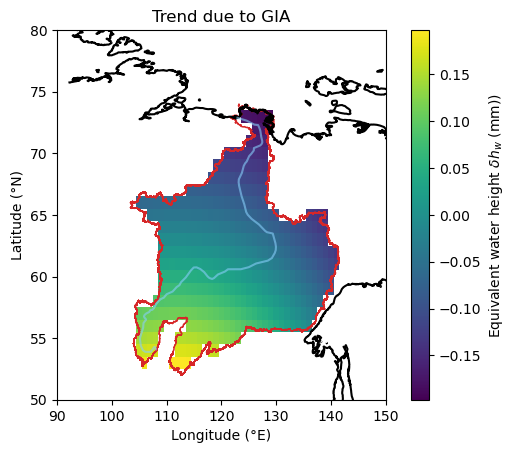

In [47]:
fig, ax = plt.subplots()

contour_plot = masked_GIA.plot(ax=ax,cmap="viridis")
# contour_plot = masked_GIA["dh(m)"].plot(ax=ax,cmap="viridis")
contour_plot.colorbar.set_label("Equivalent water height $\delta h_w$ (mm))")
ax.set_title(f"Trend due to GIA")
outline.plot(ax=ax, edgecolor="C3", facecolor="None")
main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,lw=1.5)

bounds = (90.0, 50.0, 150.0, 80.0)
coast.plot(ax=ax,color='k',zorder=1)

ax.set_ylabel("Latitude (°N)")
ax.set_xlabel("Longitude (°E)")
## optionally add background but CRS is difficult

# with rasterio.open(get_background_map("outline2", bounds)) as r:
#     rioshow(r, ax=ax,zorder=-10)
ax.set_xlim((bounds[0],bounds[2]))
ax.set_ylim((bounds[1],bounds[3]));

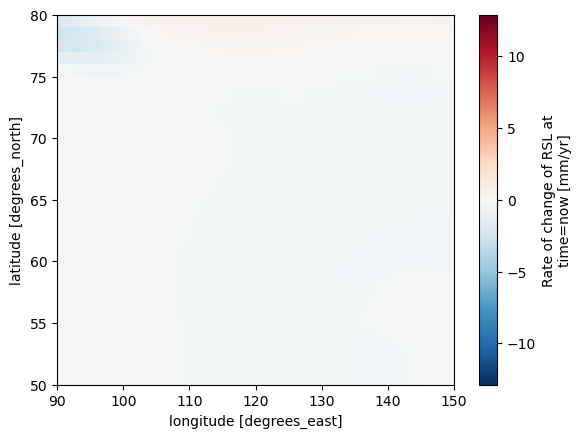

In [48]:
ds_gia = xr.open_dataset("Data\\GIA\\dsea.1grid_O512.nc")
fig, ax = plt.subplots()
ds_gia['Dsea_250'].plot(ax=ax)
bounds = (90.0, 50.0, 150.0, 80.0)
ax.set_xlim((bounds[0],bounds[2]))
ax.set_ylim((bounds[1],bounds[3]));